
Processing model: pythia-70m
Loaded norm data for Language layer 0
Loaded norm data for Language layer 1
Loaded norm data for Language layer 2
Loaded norm data for Language layer 3
Loaded norm data for Language layer 4
Loaded norm data for Safety layer 0
Loaded norm data for Safety layer 1
Loaded norm data for Safety layer 2
Loaded norm data for Safety layer 3
Loaded norm data for Safety layer 4
Loaded norm data for Random layer 0
Loaded norm data for Random layer 1
Loaded norm data for Random layer 2
Loaded norm data for Random layer 3
Loaded norm data for Random layer 4
Loaded norm data for Random1 layer 0
Loaded norm data for Random1 layer 1
Loaded norm data for Random1 layer 2
Loaded norm data for Random1 layer 3
Loaded norm data for Random1 layer 4
Loaded norm data for Random2 layer 0
Loaded norm data for Random2 layer 1
Loaded norm data for Random2 layer 2
Loaded norm data for Random2 layer 3
Loaded norm data for Random2 layer 4
Loaded norm data for Random3 layer 0
Loaded norm d

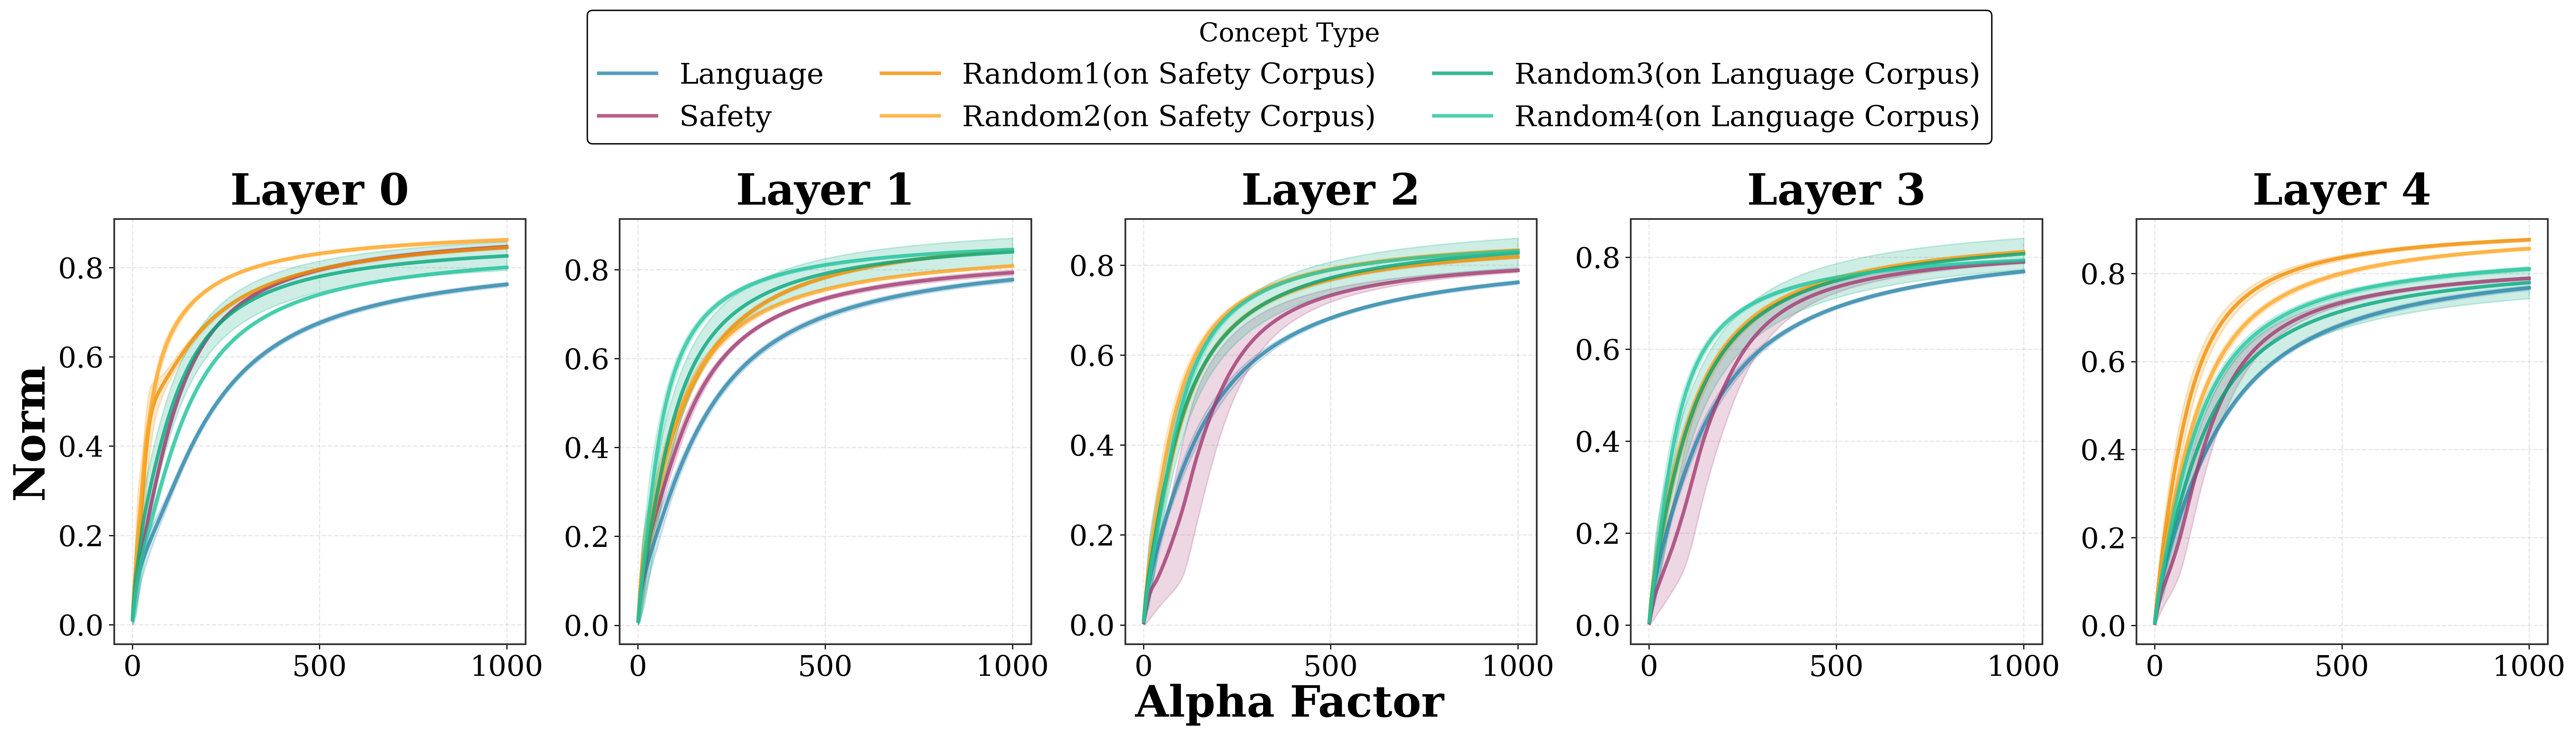

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch

# Set publication-quality style
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 13
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['grid.linewidth'] = 0.8
plt.rcParams['lines.linewidth'] = 2

# Define models and their layer counts
models = {
    'pythia-70m': 6,
    # 'pythia-160m': 12
}

# Define a sophisticated color palette
colors = {
    'Language': '#2E86AB',  # Professional blue
    'Safety': '#A23B72',     # Deep magenta
    'Random': '#F18F01',     # Warm orange
    'Random1': '#FFA726',    # Similar orange (lighter)
    'Random2': '#06A77D',    # Teal
    'Random3': '#26C6A0'     # Similar teal (lighter)
}

concept_dict = {
    'Language': 'Language',
    'Safety': 'Safety',
    'Random': 'Random1(on Safety Corpus)',
    'Random1': 'Random2(on Safety Corpus)',
    'Random2': 'Random3(on Language Corpus)',
    'Random3': 'Random4(on Language Corpus)'
}

concept_categories = ['language_en_fr', 'safety', 'random', 'random1', 'random2', 'random3']
concept_names = ['Language', 'Safety', 'Random', 'Random1', 'Random2', 'Random3']

# Create figure with 1 row x number of layers columns
for model_name, num_layers in models.items():
    print(f"\nProcessing model: {model_name}")
    # Create a figure with subplots for each layer
    fig, axes = plt.subplots(1, num_layers - 1, figsize=(5 * num_layers - 5, 5), dpi=300)
    
    # Load norm results for all concepts and layers
    norm_results = {}
    for concept_cat, concept_name in zip(concept_categories, concept_names):
        norm_results[concept_name] = {'mean': [], 'std': []}
        for layer_idx in range(num_layers-1):
            mean_norm_path = f"../../assets/linearity/{model_name}/mean_norm_{concept_cat}_layer{layer_idx}_wo_remove.pt"
            std_norm_path = f"../../assets/linearity/{model_name}/std_norm_{concept_cat}_layer{layer_idx}_wo_remove.pt"
            try:
                mean_norm_data = torch.load(mean_norm_path)
                std_norm_data = torch.load(std_norm_path)
                # Load the tensors directly
                norm_results[concept_name]['mean'].append(mean_norm_data.cpu().numpy())
                norm_results[concept_name]['std'].append(std_norm_data.cpu().numpy())
                print(f"Loaded norm data for {concept_name} layer {layer_idx}")
            except Exception as e:
                print(f"Error loading norm data for {concept_name} layer {layer_idx}: {e}")
                # Create dummy data if file doesn't exist
                alpha_factor = 1000
                norm_results[concept_name]['mean'].append(np.zeros(alpha_factor))
                norm_results[concept_name]['std'].append(np.zeros(alpha_factor))
    
    # Get alpha values (assuming alpha_factor=1000 and concept_vector_alpha=1)
    alpha_factor = len(norm_results[concept_names[0]]['mean'][0])
    alpha_values = np.arange(1, alpha_factor + 1)
    
    # Plot mean norm with std as shaded area for each layer
    for layer_idx in range(num_layers-1):
        ax = axes[layer_idx] if num_layers > 2 else axes
        for concept_name in concept_names:
            mean_norm = norm_results[concept_name]['mean'][layer_idx]
            std_norm = norm_results[concept_name]['std'][layer_idx]
            
            # Plot mean line
            ax.plot(alpha_values, mean_norm, 
                   color=colors[concept_name], 
                   label=concept_dict[concept_name], 
                   linewidth=2.5, alpha=0.8)
            
            # Add shaded area for std
            ax.fill_between(alpha_values, 
                           mean_norm - std_norm, 
                           mean_norm + std_norm,
                           color=colors[concept_name], 
                           alpha=0.2)
        
        ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
        ax.set_axisbelow(True)
        ax.set_title(f'Layer {layer_idx}', fontweight='bold', pad=10, fontsize=30)
        if layer_idx == 0:
            ax.set_ylabel('Norm', fontweight='bold', fontsize=30)
        for spine in ax.spines.values():
            spine.set_linewidth(1.2)
            spine.set_color('#333333')
    
    # Add a single shared x-axis label at the bottom center
    fig.text(0.5, -0.04, 'Alpha Factor', ha='center', fontweight='bold', fontsize=30)
    
    # Create a single legend at the top of the figure
    handles, labels = (axes[0] if num_layers > 2 else axes).get_legend_handles_labels()
    fig.legend(handles, labels, title='Concept Type', loc='upper center', 
               bbox_to_anchor=(0.5, 1.35), ncol=3, frameon=True, 
               fancybox=True, shadow=False, framealpha=0.95, 
               edgecolor='black', fontsize=20, title_fontsize=18)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92, bottom=0.1)  # Make room for the legend at the top and x-label at bottom
    plt.savefig(f'../../assets/figs/linearity/{model_name}_norm_by_layer.pdf', format='pdf', bbox_inches='tight', dpi=300)
    plt.show()
